In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import statsmodels.api as sm

# Event Studies

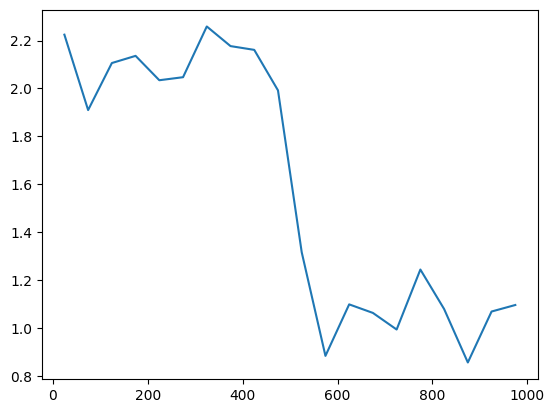

In [81]:
t = np.arange(1000)
t0 = 500
Y = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, 1000)
plt.plot(t.reshape(-1, 50).mean(axis = 1), Y.reshape(-1, 50).mean(axis = 1))

In [93]:
# Scenario: after a new grocery store opens up, does our (old) store reduce the price of a pound of apples?
# First experiment: yes, it reduces
t = np.arange(1000)
t0 = 500
Y = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, (1000,))
# Test
After = 1 * (t >= t0)
t_After = (t - t0) * After
X = sm.add_constant(pd.DataFrame({"After": After, "t_After": t_After, "t": t}))
results = sm.OLS(Y, X).fit()
results.tvalues

const      23.290559
After      -6.957643
t_After     0.054258
t          -0.760180
dtype: float64

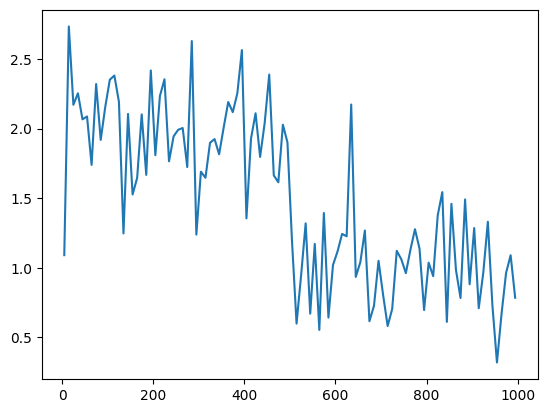

In [94]:
bin_size = 10
plt.plot(t.reshape(-1, bin_size).mean(axis = 1), Y.reshape(-1, bin_size).mean(axis = 1))

In [95]:
results.tvalues

const      23.290559
After      -6.957643
t_After     0.054258
t          -0.760180
dtype: float64

In [99]:
results.pvalues < 0.0125 # Bonferroni correction

const       True
After       True
t_After    False
t          False
dtype: bool

const      1.948646
After     -0.057949
t_After   -0.000457
t          0.000202
dtype: float64

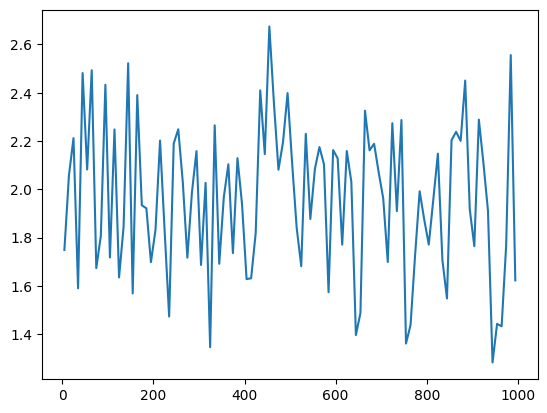

In [100]:
# Now let's define a function to do this for us.
def event_study(num_times, before_const, after_const, before_slope, after_slope, sigma, bin_size):
    t = np.arange(num_times)
    t0 = int(num_times / 2)
    Y = before_const * (t < t0) + before_slope * t + after_const * (t >= t0) + (after_slope - before_slope) * (t - t0) * (t >= t0) + np.random.normal(0, sigma, (num_times,))
    # Test
    After = 1 * (t >= t0)
    t_After = (t - t0) * After
    X = sm.add_constant(pd.DataFrame({"After": After, "t_After": t_After, "t": t}))
    results = sm.OLS(Y, X).fit()
    plt.plot(t.reshape(-1, bin_size).mean(axis = 1), Y.reshape(-1, bin_size).mean(axis = 1))
    return results

results = event_study(num_times = 1000, before_const = 2.0, after_const = 1.9, before_slope = 0, after_slope = 0, sigma = 1, bin_size = 10)
results.params

const      2.002322e+00
After     -9.955057e-02
t_After   -4.048562e-07
t          4.266934e-08
dtype: float64

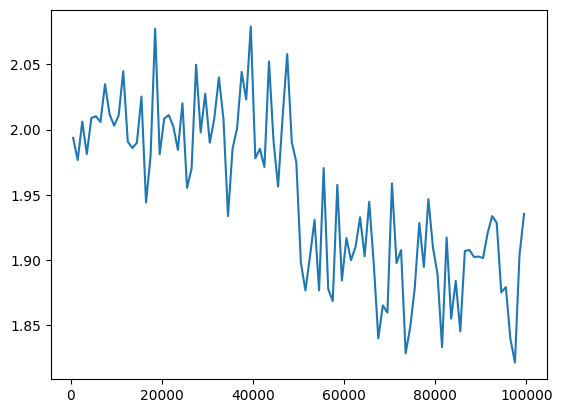

In [101]:
results = event_study(num_times = 100000, before_const = 2.0, after_const = 1.9, before_slope = 0, after_slope = 0, sigma = 1, bin_size = 1000)
results.params

In [60]:
results.tvalues

const      224.331478
After       -8.110871
t_After     -0.071092
t            0.046814
dtype: float64

const      2.044712
After     -0.010883
t_After    0.009742
t         -0.000259
dtype: float64

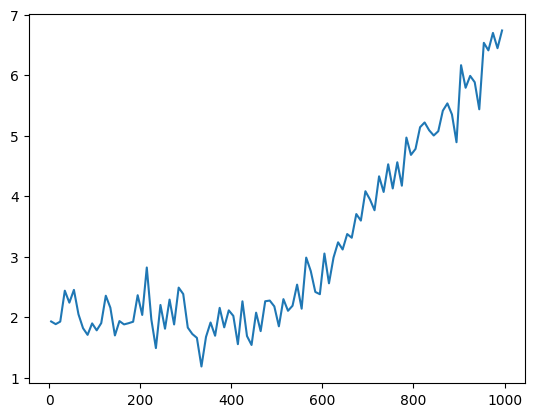

In [103]:
results = event_study(num_times = 1000, before_const = 2.0, after_const = 1.9, before_slope = 0, after_slope = 0.01, sigma = 1, bin_size = 10)
results.params

In [64]:
results.tvalues

const      19.962351
After      -3.168290
t_After    22.470352
t           1.650802
dtype: float64

# Differences-in-differences

In [104]:
t = np.arange(1000)
t0 = 500
Y_A = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, (1000,))
Y_B = 1.5 + np.random.normal(0, 1, (1000,))
Y = np.concatenate((Y_A, Y_B))
group_A = np.concatenate((np.ones(1000), np.zeros(1000)))
After = np.tile(1 * (t >= t0), 2)
X = sm.add_constant(pd.DataFrame({"alpha_group": group_A, "alpha_time": After, "beta_1": group_A * After}))
results = sm.OLS(Y, X).fit()
results.params

const          1.517583
alpha_group    0.527395
alpha_time    -0.045642
beta_1        -1.041571
dtype: float64

In [109]:
# Scenario: a new grocery store opens up in town A but not town B.  Do the stores in town A reduce the price of a pound of apples
# because of this event?  Or do they reduce it for other reasons?

# First experiment: yes, it reduces
t = np.arange(1000)
t0 = 500
Y_A = 2 * (t < t0) + 1 * (t >= t0) + np.random.normal(0, 1, (1000,))
Y_B = 1.5 + np.random.normal(0, 1, (1000,))
Y = np.concatenate((Y_A, Y_B))
group_A = np.concatenate((np.ones(1000), np.zeros(1000)))
After = np.tile(1 * (t >= t0), 2)
X = sm.add_constant(pd.DataFrame({"alpha_group": group_A, "alpha_time": After, "beta_1": group_A * After}))
results = sm.OLS(Y, X).fit()
results.params

const          1.383384
alpha_group    0.632185
alpha_time     0.101002
beta_1        -1.152585
dtype: float64

In [110]:
results.pvalues

const          2.055372e-177
alpha_group     8.443944e-24
alpha_time      1.037303e-01
beta_1          7.378451e-38
dtype: float64

In [111]:
df = pd.DataFrame({"Y": Y, "group_A": group_A, "After": After})
pivot = pd.pivot_table(df, index = "group_A", columns = "After", values = "Y", aggfunc = "mean")
pivot

After,0,1
group_A,,
0.0,1.383384,1.484387
1.0,2.015569,0.963987


In [48]:
df = pd.DataFrame({"Y": Y, "group_A": group_A, "After": After})
pivot = pd.pivot_table(df, index = "group_A", columns = "After", values = "Y", aggfunc = "mean")
pivot

After,0,1
group_A,,
0.0,1.522993,1.540843
1.0,2.056710,0.968017


<Axes: xlabel='After', ylabel='group_A'>

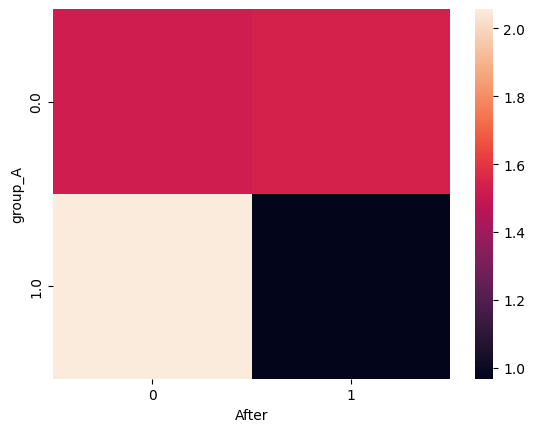

In [49]:
sns.heatmap(pivot)

In [81]:
def DID(num_times, before_const_A, after_const_A, before_const_B, after_const_B, sigma):
    t = np.arange(num_times)
    t0 = int(num_times / 2)
    Y_A = before_const_A * (t < t0) + after_const_A * (t >= t0) + np.random.normal(0, sigma, (num_times,))
    Y_B = before_const_B * (t < t0) + after_const_B * (t >= t0) + np.random.normal(0, sigma, (num_times,))
    Y = np.hstack((Y_A, Y_B))
    group_A = np.hstack((np.ones(num_times), np.zeros(num_times)))
    After = np.hstack((1 * (t >= t0), 1 * (t >= t0)))
    X = sm.add_constant(pd.DataFrame({"alpha_group": group_A, "alpha_time": After, "beta_1": group_A * After}))
    results = sm.OLS(Y, X).fit()
    return results

results = DID(num_times = 1000, before_const_A = 1.0, after_const_A = 2.0, before_const_B = 2.0, after_const_B = 3.0, sigma = 1)
results.params

const          1.978411
alpha_group   -0.980882
alpha_time     0.967639
beta_1         0.009076
dtype: float64

In [82]:
results.tvalues

const          43.766256
alpha_group   -15.343510
alpha_time     15.136360
beta_1          0.100385
dtype: float64

In [25]:
results = DID(num_times = 1000, before_const_A = 1.0, after_const_A = 3.0, before_const_B = 2.0, after_const_B = 3.0, sigma = 1)
results.params

const          1.958503
alpha_group   -0.993788
alpha_time     0.984086
beta_1         1.139168
dtype: float64